In [35]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [5]:

!unzip -q "/content/Teeth DataSet.zip" -d "/content"


In [36]:

base_dir = "/content/Teeth_Dataset"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Testing")


In [37]:
import shutil


unwanted_folders = ['out', 'output', 'outputs']


for folder_name in unwanted_folders:
    folder_path = os.path.join(test_dir, folder_name)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f" Deleted: {folder_path}")
    else:
        print(f" Not found: {folder_path}")


❌ Not found: /content/Teeth_Dataset/Testing/out
❌ Not found: /content/Teeth_Dataset/Testing/output
❌ Not found: /content/Teeth_Dataset/Testing/outputs


In [38]:

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


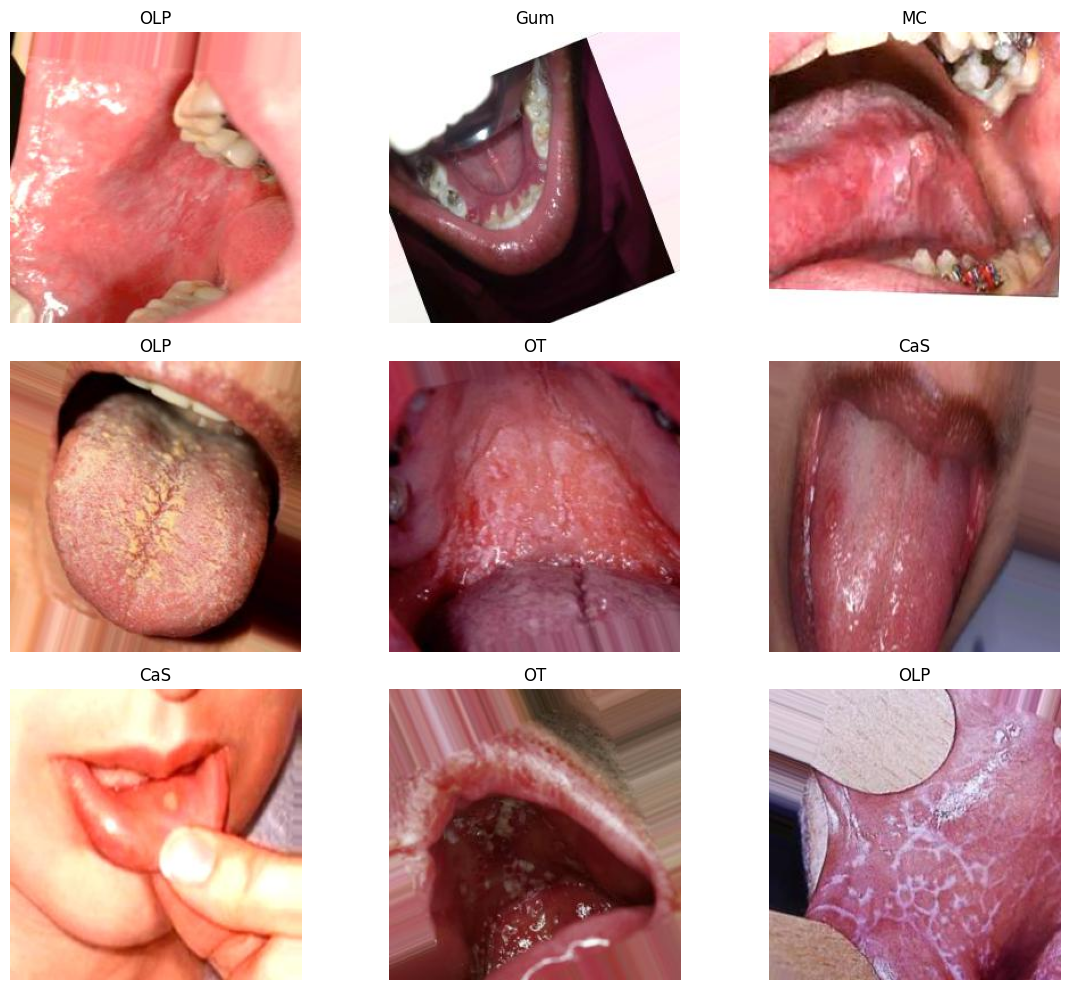

In [39]:
import matplotlib.image as mpimg
import random


def show_random_images_from_folder(folder, num_images=9):
    class_names = os.listdir(folder)
    class_names = [name for name in class_names if os.path.isdir(os.path.join(folder, name))]

    plt.figure(figsize=(12, 10))

    for i in range(num_images):
        class_name = random.choice(class_names)
        class_path = os.path.join(folder, class_name)
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)

        img = mpimg.imread(image_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images_from_folder(train_dir)


In [40]:
from collections import defaultdict

def count_images_per_class(directory):
    class_counts = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("Train Set:", count_images_per_class(train_dir))
print("Val Set:", count_images_per_class(val_dir))
print("Test Set:", count_images_per_class(test_dir))


Train Set: defaultdict(<class 'int'>, {'OC': 324, 'OT': 393, 'MC': 540, 'OLP': 540, 'Gum': 360, 'CoS': 450, 'CaS': 480})
Val Set: defaultdict(<class 'int'>, {'OC': 108, 'OT': 131, 'MC': 180, 'OLP': 180, 'Gum': 120, 'CoS': 149, 'CaS': 160})
Test Set: defaultdict(<class 'int'>, {'OC': 108, 'OT': 131, 'MC': 180, 'OLP': 180, 'Gum': 120, 'CoS': 149, 'CaS': 160})


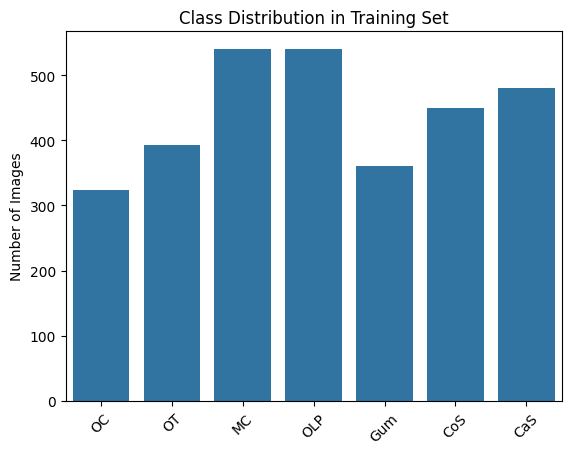

In [41]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(folder, title):
    class_counts = {cls: len(os.listdir(os.path.join(folder, cls)))
                    for cls in os.listdir(folder)
                    if os.path.isdir(os.path.join(folder, cls))}
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(f"Class Distribution in {title}")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_dir, "Training Set")


In [42]:

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [43]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]


from sklearn.utils import class_weight
import numpy as np

labels = train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(weights))


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.2469 - loss: 1.9392

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 476ms/step - accuracy: 0.2479 - loss: 1.9368 - val_accuracy: 0.5049 - val_loss: 1.3858 - learning_rate: 1.0000e-04
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step - accuracy: 0.5478 - loss: 1.2618 - val_accuracy: 0.6177 - val_loss: 1.1226 - learning_rate: 1.0000e-04
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.6190 - loss: 1.0436 - val_accuracy: 0.6576 - val_loss: 0.9883 - learning_rate: 1.0000e-04
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 391ms/step - accuracy: 0.6593 - loss: 0.9424 - val_accuracy: 0.7130 - val_loss: 0.8192 - learning_rate: 1.0000e-04
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 389ms/step - accuracy: 0.7188 - loss: 0.8088 - val_accuracy: 0.7335 - val_loss: 0.7911 - learning_rate: 1.0000e-04
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.7507 - loss: 0.7290 - val_accuracy: 0.7685 - val_loss: 0.6987 - learning_rate: 1.0000e-04
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 391ms/step - accuracy: 0.76

In [44]:

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

model.save("teeth_classifier_mobilenetv2.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9761 - loss: 0.1069


Test Accuracy: 95.72%


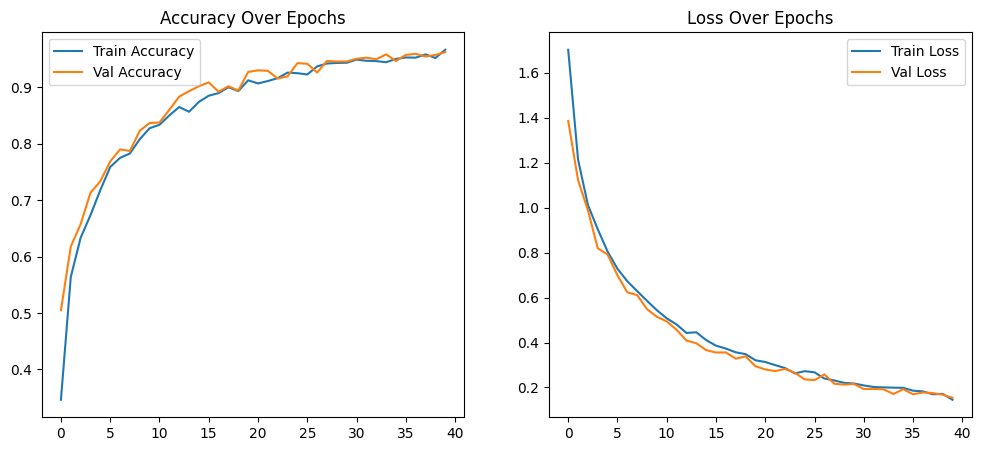

In [45]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step
              precision    recall  f1-score   support

         CaS       0.98      0.98      0.98       160
         CoS       0.99      0.99      0.99       149
         Gum       0.97      0.99      0.98       120
          MC       0.96      0.94      0.95       180
          OC       0.88      0.98      0.93       108
         OLP       0.95      0.89      0.92       180
          OT       0.98      0.95      0.97       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028



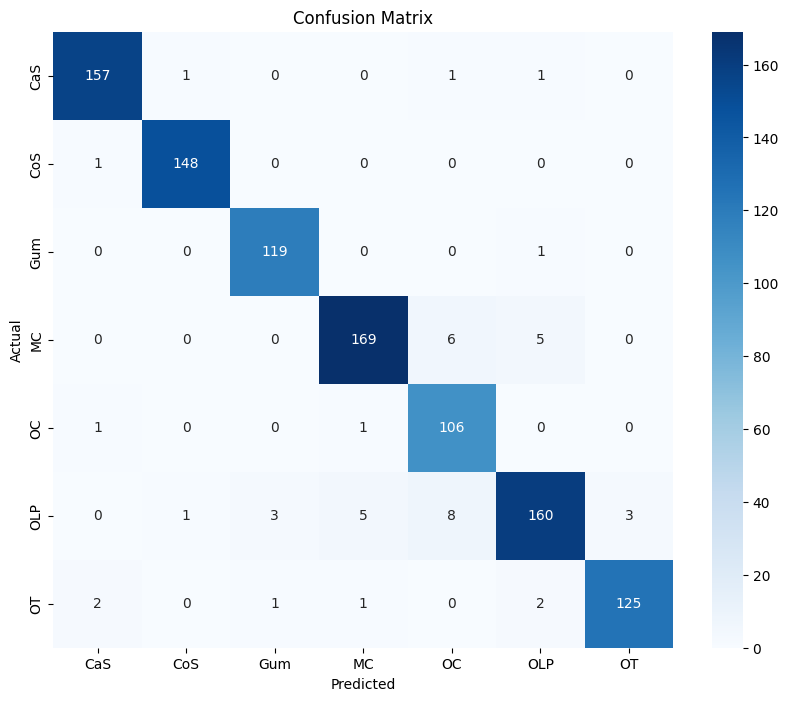

In [46]:
# 📉 9. CONFUSION MATRIX & CLASSIFICATION REPORT
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [49]:
import numpy as np


y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [60]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_colored_predictions(n=12, columns=4):
    indices = list(range(len(test_generator.filepaths)))
    random.shuffle(indices)

    rows = (n + columns - 1) // columns
    plt.figure(figsize=(3 * columns, 3 * rows))

    for i in range(n):
        idx = indices[i]
        img_path = test_generator.filepaths[idx]
        img = mpimg.imread(img_path)
        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred[idx]]
        correct = true_label == pred_label

        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
        color = 'green' if correct else 'red'
        title = f" {pred_label}" if correct else f" Pred: {pred_label}\nTrue: {true_label}"
        plt.title(title, color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-60-1842661097.py:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


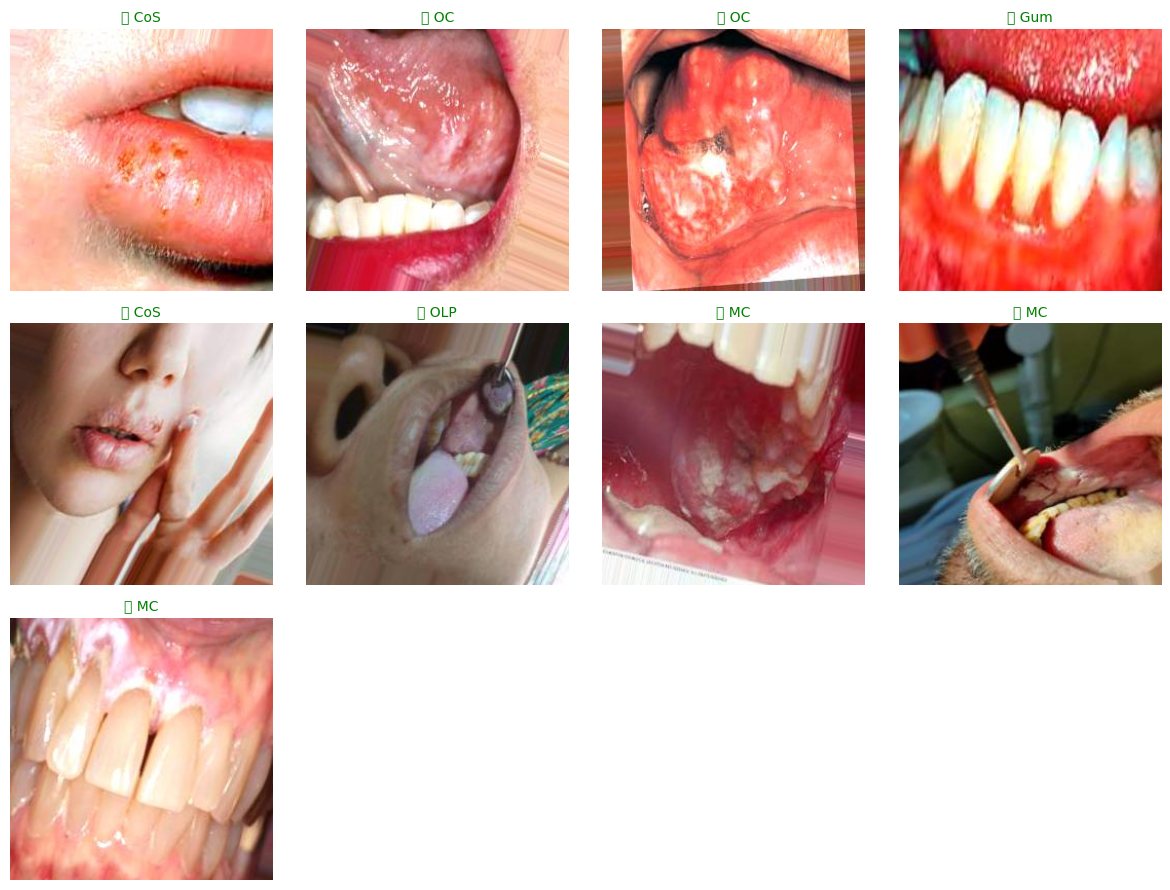

In [61]:
show_colored_predictions(9)

